In [1]:
import numpy as np
import pandas as pd
import re
# from spellchecker import SpellChecker

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.matcher import Matcher
from spacy.language import Language
# from spacymoji import Emoji
from spacy.tokens import Doc

nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

2023-09-27 18:42:08.688307: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-27 18:42:08.757006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 18:42:11.217032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-27 18:42:11.247049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read 

0it [00:00, ?it/s]

Read the data as a dataframe and return inbound as a Pandas series containing user inputs to be tokenized

In [2]:
%%time

import pandas as pd

data = pd.read_csv('common_issues.csv', encoding='utf-8')

show = lambda x: x.tail(5).style.set_properties(**{'background-color': 'black', 
    'color': 'lawngreen',                       
    'border-color': 'white'})\
.applymap(lambda x: f"color: {'lawngreen' if isinstance(x,str) else 'cyan'}")\
.background_gradient(cmap='Blues')

inbound = data['Input']

show(data)

CPU times: user 19.1 ms, sys: 9.6 ms, total: 28.7 ms
Wall time: 38 ms


<timed exec>:8: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.


,Intent,Input,Random sort
637,Others,"Hey, I'm taking a sick day from school because of a doctor's appointment.",0.811353
638,Others,Right-click context menu not appearing when tapping the touchpad.,0.479299
639,Others,My Apple Pencil is not in working condition.,0.604403
640,Others,Software update needed to fix internet connectivity issues on the laptop.,0.936502
641,Others,Incorrect Wi-Fi password entered on the iPad.,0.833335


Plot count vectorization (bags of words)

/home/rachtrx/anaconda3/envs/chatbot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rachtrx/anaconda3/envs/chatbot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/rachtrx/anaconda3/envs/chatbot/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


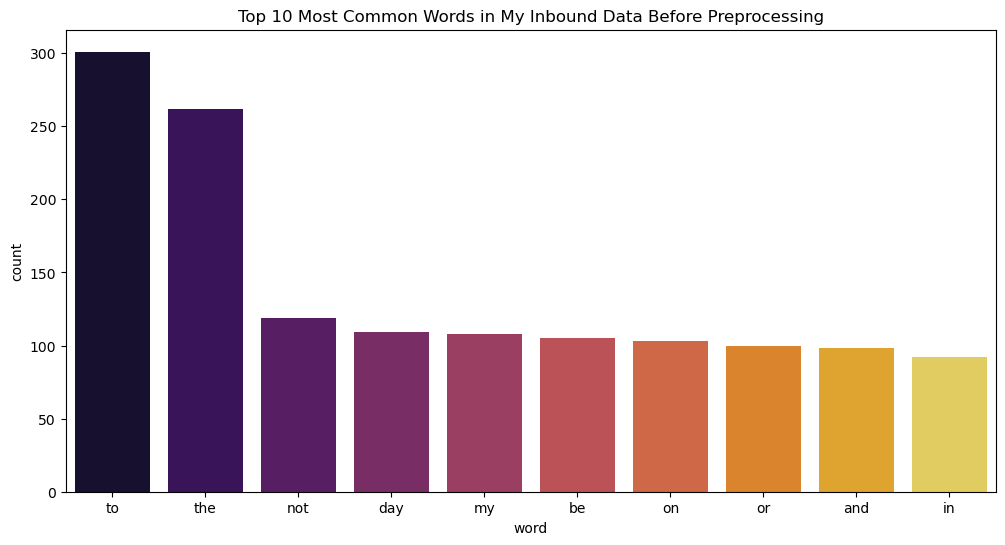

In [3]:
# Writing a function to plot the counts that are in the data



def top10_bagofwords(data, output_name, title):
    ''' Taking as input the data and plots the top 10 words based on counts in this text data'''
    cv = CountVectorizer()
    inbound = cv.fit_transform(data)
    inbound # Output will be a sparse matrix
    # Inspecting of often contractions and colloquial language is used
    word_counts = np.array(np.sum(inbound, axis=0)).reshape((-1,)) # convert to 2D numpy array and get sum along columns, then convert to 1D array
    words = np.array(cv.get_feature_names_out()) # get the columns (features)
    words_df = pd.DataFrame({"word":words, 
                             "count":word_counts})
    words_rank = words_df.sort_values(by="count", ascending=False)
    # words_rank.to_csv('words_rank.csv') # Storing it in a csv so I can inspect and go through it myself
    words_rank.head()
    # Visualizing top 10 words
    plt.figure(figsize=(12,6))
    sns.barplot(x=words_rank['word'][:10], y=words_rank['count'][:10].astype(int), palette='inferno')
    plt.title(title)
    
    # Saving
    # plt.savefig(f'visualizations/{output_name}.png')
    
    plt.show()

top10_bagofwords(inbound, 'most_common_before' ,'Top 10 Most Common Words in My Inbound Data Before Preprocessing')

# Data Processing

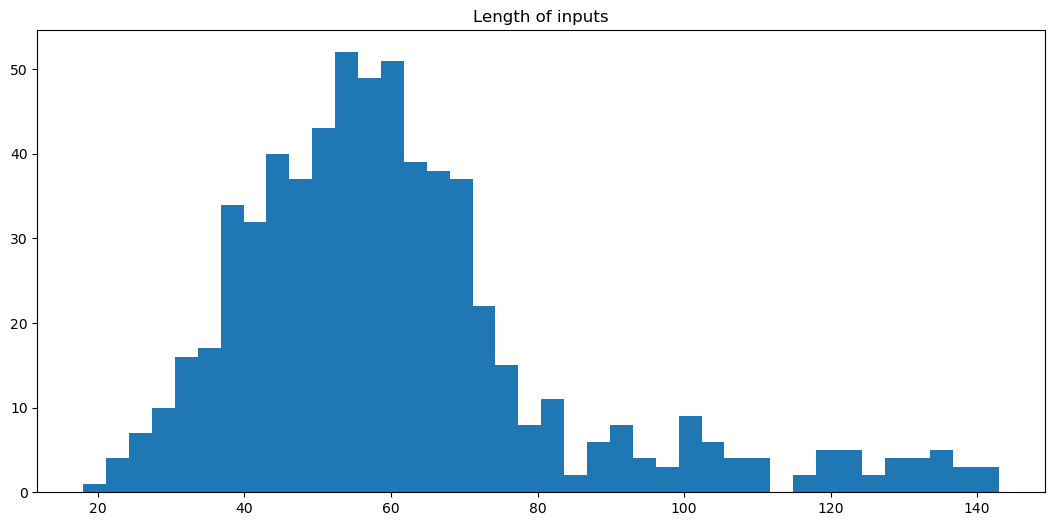

In [4]:
def visualize_lengths(data,title):
    '''Visualizing lengths of tokens in each tweet'''
    lengths = [len(i) for i in data]
    plt.figure(figsize=(13,6))
    plt.hist(lengths, bins = 40)
    plt.title(title)
    plt.show()

visualize_lengths(inbound, "Length of inputs")


In [5]:
puncts = ['\u200d','?', '....','..','...','','@','#', ',', '.', '"', ':', ')', '(', '-', '!', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '*', '+', '\\', 
    '•', '~', '£', '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', 
    '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
    '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 
    'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', 
    '¹', '≤', '‡', '√', '!','🅰','🅱']

contraction_colloq_dict = {"btw": "by the way", "ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have"}

In [6]:
def visualize_lengths(data,title):
    '''Visualizing lengths of tokens in each tweet'''
    lengths = [len(i) for i in data]
    plt.figure(figsize=(13,6))
    plt.hist(lengths, bins = 40)
    plt.title(title)
    plt.show()

def create_remove_component(component_name, stuff_to_remove):
    @Language.component(component_name)
    def remove_from_list(doc):
        '''Function that removes specific items from list of tokens'''
        new_tokens = [token for token in doc if token.text not in stuff_to_remove]
        return Doc(doc.vocab, words=[token.text for token in new_tokens])
    return remove_from_list

@Language.component("remove_links")
def remove_links(doc):
    tokens = [token for token in doc if not token.like_url]
    return Doc(doc.vocab, words=[t.text for t in tokens])

@Language.component("correct_spellings")
def correct_spellings(doc):
    corrected_text = []
    for token in doc:
        corrected_text.append(spell.correction(token))
    return corrected_text


# Expanding contractions and colloquial language
def replace_colloquials(component_name, dic):
    @Language.component(component_name)
    def replace_from_dict(doc):
        new_tokens = []
        for token in doc:
            if token.text.lower() in dic.keys():
                new_tokens.extend(dic[token.text.lower()].split())
            else:
                new_tokens.append(token.text)
        new_doc = Doc(nlp.vocab, new_tokens)
        return new_doc
    return replace_from_dict

@Language.component("replace_colloquial")
def extract_emojis():
    return [c for c in s if c not in emoji.UNICODE_EMOJI]

@Language.component("set_max_length")
def limit_length(x, max_tokens, min_tokens):
    ''' Inputs a list and drops it out of the document if the document has more than the max and less than the min'''
    output = x
    if len(x) > max_tokens:
        output = np.nan
    if len(x) <= min_tokens:
        output = np.nan
    return output

def add_to_pipeline(nlp, component_name, before=None, after=None):
    if component_name in nlp.pipe_names:
        nlp.remove_pipe(component_name)
    if before is not None:
        nlp.add_pipe(component_name, before=before)
    elif after is not None:
        nlp.add_pipe(component_name, after=after)

#SECTION maybe can remove punctuation

In [7]:
def modify_pipeline():
    '''tokenizer function that takes in pandas series and returns pandas series'''
    
    # 3. Removing the punctuation
    
    create_remove_component("remove_punctuation", puncts)
    add_to_pipeline(nlp, "remove_punctuation", before = "tok2vec")
    
#     # 3.1. Removing links
    create_remove_component("remove_links", puncts)
    add_to_pipeline(nlp, "remove_links", before = "tok2vec")
    
#     print(f'3. Removed the links. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
#     visualize_lengths(data, 'Length of Tokens after Step 3')

#     # 4. Checking for and correcting mispellings
#     spell = SpellChecker()
    
#     # Skipping this step first because it takes way too long
# #     data = data.progress_apply(correct_spellings)
    
#     print(f'4. Applied automispelling corrections. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
    
    
#     # 5. Removing the stop words, utilizing the same remove_from_list function defined above
    
#     data = data.progress_apply(remove_from_list, stuff_to_remove = stop_words)
    
#     print(f'5. Removed the stop words. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
#     visualize_lengths(data, 'Length of Tokens after Step 4')
    
#     # 6. Expanding contractions and colloquial language
    
#     data = data.progress_apply(replace_from_dict, dic = contraction_colloq_dict)
#     print(f'6. Expanded contractions into extra tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
#     visualize_lengths(data, 'Length of Tokens after Step 5')
    
#     # 8. Lemmatization

#     data = data.progress_apply(lemmatize_list)
#     print(f'8. Lemmatized the tokens. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
#     visualize_lengths(data, 'Length of Tokens after Step 8')   
   
#     # Removing again to make sure I get everything
#     data = data.progress_apply(remove_from_list, stuff_to_remove = puncts)

#     # 9.1. Removing emojis -- (UPDATE) in a way that preserves Series indexes
    
#     unique_emojis = [i[0] for i in emoji.UNICODE_EMOJI]
#     data = data.apply(remove_from_list, stuff_to_remove = unique_emojis)
    
#     # 9.2. Removing numbers -- (UPDATE) also in a way that preserves Series indexes
#     # Using nested list comprehension
#     data = data.progress_apply(clean_numbers)
    
#     print(f'9. Removed emojis and numbers. Shape is still {data.shape}. \n \n Peek: \n {data.head()}')
#     visualize_lengths(data, 'Length of Tokens after Step 9')   
    
#     # 10. Limiting length of Tweet
#     max_tokens = 50
#     min_tokens = 5
#     data = data.progress_apply(limit_length, min_tokens = min_tokens, max_tokens = max_tokens)
#     # Dropping all nan values, which are the token limits that didn't meet the thresholding requirements
#     data = data.dropna()
#     print(f'10. Limited each tweet to a max of {max_tokens} tokens and a min of {min_tokens} tokens. Shape is now {data.shape}. \n \n Peek: \n {data.head()}')
#     visualize_lengths(data, 'Length of Tokens after Step 10')
    
    return 

Modify the pipeline and call it to return the tokenized user input

1. Original shape of data is (642,)
3. Removed empty tokens and punctuation. Shape is still (642,). 
 
 Peek: 
 0    (The, iPad, screen, is, frozen, in, landscape,...
1         (OneDrive, not, syncing, files, or, folders)
2    (Keyboard, backlight, not, working, as, expected)
3             (My, Apple, Pencil, is, n't, responding)
4    (Can, I, request, a, 3, day, medical, certific...
Name: Input, dtype: object


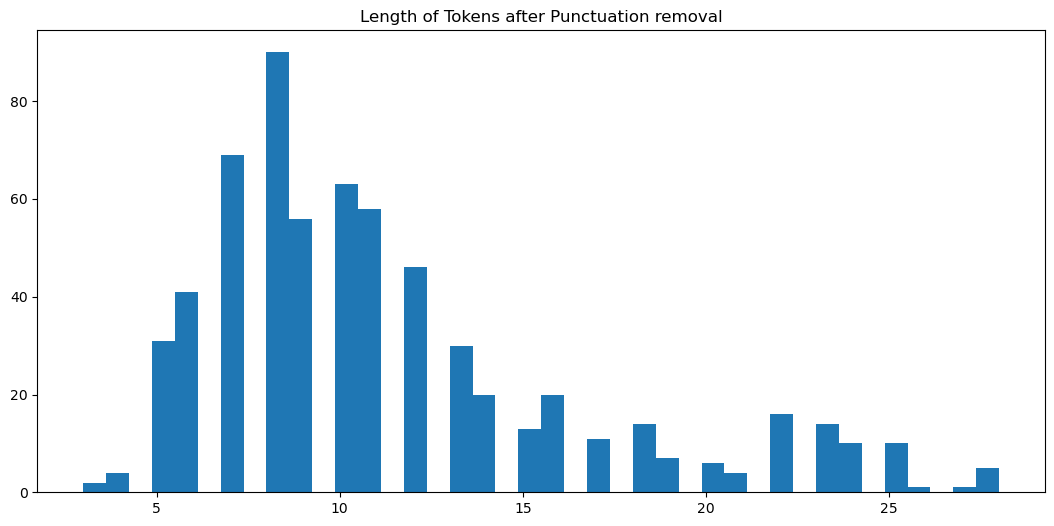

(270, Screen flickering uncontrollably )

In [8]:
# inbound = inbound.str.lower()

modify_pipeline()

print(f'1. Original shape of data is {inbound.shape}') # inbound = data['Inbound']

processed_input = inbound.apply(nlp)
print(f'3. Removed empty tokens and punctuation. Shape is still {processed_input.shape}. \n \n Peek: \n {processed_input.head()}')
visualize_lengths(processed_input, 'Length of Tokens after Punctuation removal')

shortest_idx = processed_input.apply(len).idxmin()
shortest_array = processed_input[shortest_idx]

shortest_idx, shortest_array

In [9]:
processed_input.head()


0    (The, iPad, screen, is, frozen, in, landscape,...
1         (OneDrive, not, syncing, files, or, folders)
2    (Keyboard, backlight, not, working, as, expected)
3             (My, Apple, Pencil, is, n't, responding)
4    (Can, I, request, a, 3, day, medical, certific...
Name: Input, dtype: object

Return a DF of the original and processed data

In [10]:
label = data['Intent']
real_input = data['Input']

processed = pd.DataFrame({'Processed Input': processed_input, 'Real Input': real_input, 'Label': label})

processed

,Processed Input,Real Input,Label
0,"(The, iPad, screen, is, frozen, in, landscape,...",The iPad screen is frozen in landscape or port...,Others
1,"(OneDrive, not, syncing, files, or, folders)",OneDrive not syncing files or folders.,Others
2,"(Keyboard, backlight, not, working, as, expected)",Keyboard backlight not working as expected.,Others
3,"(My, Apple, Pencil, is, n't, responding)",My Apple Pencil isn't responding.,Others
4,"(Can, I, request, a, 3, day, medical, certific...",Can I request a 3-day medical certificate star...,MC
...,...,...,...
637,"(Hey, I, 'm, taking, a, sick, day, from, schoo...","Hey, I'm taking a sick day from school because...",Others
638,"(Right, click, context, menu, not, appearing, ...",Right-click context menu not appearing when ta...,Others
639,"(My, Apple, Pencil, is, not, in, working, cond...",My Apple Pencil is not in working condition.,Others
640,"(Software, update, needed, to, fix, internet, ...",Software update needed to fix internet connect...,Others


In [11]:
processed_input.to_pickle('objects/processed_input.pkl')
processed.to_pickle('objects/processed.pkl')